In [1]:
import pandas as pd
import tarfile
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np

%run -i "functions/unzip.py"
%run -i "functions/scrape_platforms.py"
%run -i "functions/scrape_SotU.py"
%run -i "functions/create_ts.py"
%run -i "functions/party_splits.py"
%run -i "functions/make_preds.py"
%run -i "functions/store_predictions.py"

# Survey Data
#### Weights
This function will encorporate sample weights provided by the University of Chicago General Social Survey, which is the source of all the survey data used in this analysis.

In [2]:
weights = unzip('Weights')

def weight(df):
    return df.loc[df.index.repeat(round(weights['Weight variable']*10, 0))].reset_index()

## Voter Identity
### Clean- Voter Identity

In [3]:
party = unzip('Voter_Identity')
party = party[['year', 'Political party affiliation']]
party = weight(party)
party.drop('index', axis = 1, inplace= True)
party.head()

,year,Political party affiliation
0,1972,"Ind,near dem"
1,1972,"Ind,near dem"
2,1972,"Ind,near dem"
3,1972,"Ind,near dem"
4,1972,Not str democrat


In [4]:
party.rename(columns = {'Political party affiliation':'party'}, inplace=True)
party['party'].value_counts()

Not str democrat      131833
Not str republican    101264
Independent           100052
Strong democrat        99652
Ind,near dem           76687
Strong republican      63506
Ind,near rep           58747
Other party            10708
No answer               4099
Don't know               143
Name: party, dtype: int64

In [5]:
party.loc[party['party']=='Not str democrat', 'party']= 'Democrat'
party.loc[party['party']=='Not str republican', 'party']= 'Republican'
party.loc[party['party']=='Strong democrat', 'party']= 'Strong Democrat'
party.loc[party['party']=='Ind,near dem', 'party']= 'Lean Democrat'
party.loc[party['party']=='Strong republican', 'party']= 'Strong Republican'
party.loc[party['party']=='Ind,near rep', 'party']= 'Lean Republican'
party.loc[party['party']=='Other party', 'party']= 'Other'
parties = ['Democrat', 'Independent', 'Lean Democrat', 
           'Lean Republican', 'Other', 'Republican', 
           'Strong Democrat', 'Strong Republican']
percent_parties = create_ts(party, parties)
overall = pd.DataFrame(percent_parties['year'])
overall['Democrat']= (percent_parties['Lean Democrat']
                      +percent_parties['Democrat']
                      +percent_parties['Strong Democrat']) 
overall['Republican']= (percent_parties['Lean Republican']
                        +percent_parties['Republican']
                        +percent_parties['Strong Republican'])
overall['Independent']= percent_parties['Independent']
overall['Other'] = percent_parties['Other']

### EDA- Party Affiliation

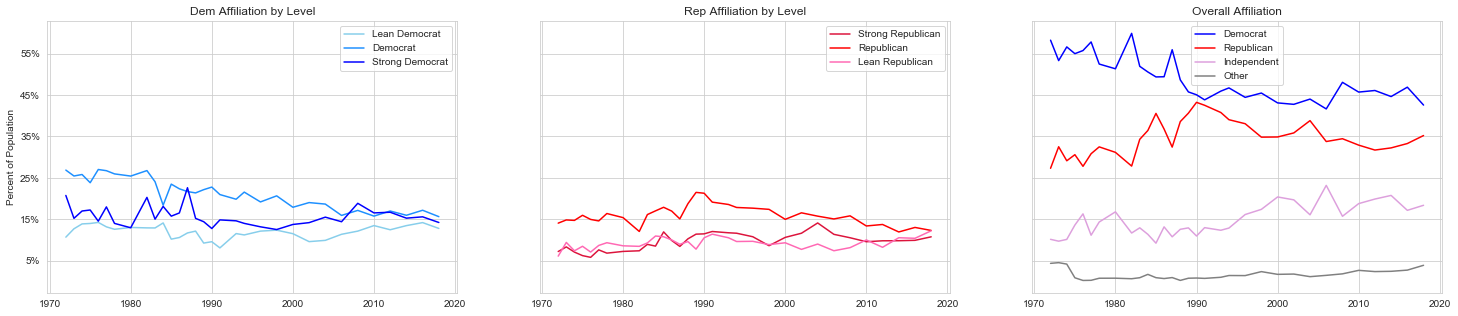

In [6]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(25,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)


sns.lineplot(x= 'year', y = 'Lean Democrat', data= percent_parties, 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(x= 'year', y = 'Democrat', data= percent_parties, 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y = 'Strong Democrat', data= percent_parties, 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
ax1.set_title('Dem Affiliation by Level')
ax1.set_ylabel('Percent of Population')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y = 'Strong Republican', data= percent_parties, 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(x= 'year', y = 'Republican', data= percent_parties, 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y = 'Lean Republican', data= percent_parties, 
             color= 'hotpink', label= 'Lean Republican', ax = ax2);
ax2.set_title('Rep Affiliation by Level')
ax2.set_xlabel('')

sns.lineplot(x='year', y='Democrat', data=overall, 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(x='year', y='Republican', data=overall, 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(x='year', y='Independent', data=overall, 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(x='year', y='Other', data=overall, 
             color= 'grey', label= 'Other', ax = ax3);
ax3.set_title('Overall Affiliation')
ax3.set_xlabel('')

plt.yticks(ticks=[.05, .15, .25, .35, .45, .55], 
           labels=['5%','15%', '25%', '35%', '45%', '55%']);

### Time Series Predictions- Party Affiliation
Using a function designed to optimize a time series model I will attempt to predict the levels of affiliation up to the 2024 presidential election. 

In [7]:
party_aff_lev = store_predictions(percent_parties)
party_aff_lev.to_excel('data/predictions/voter/leveled.xlsx')

C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmode

(1, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 3)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(1, 1, 1)


,Democrat,Predicted Democrat,Independent,Predicted Independent,Lean Democrat,Predicted Lean Democrat,Lean Republican,Predicted Lean Republican,Other,Predicted Other,Predicted Republican,Republican,Predicted Strong Democrat,Strong Democrat,Predicted Strong Republican,Strong Republican
1972,0.268597,NaN,0.101286,NaN,0.106590,NaN,0.060721,NaN,0.043248,NaN,NaN,0.140414,NaN,0.207314,NaN,0.071830
1973,0.254349,NaN,0.096850,NaN,0.126805,NaN,0.093828,NaN,0.044933,NaN,NaN,0.148163,NaN,0.152059,NaN,0.083014
1974,0.257948,NaN,0.101148,NaN,0.138574,NaN,0.073600,NaN,0.041461,NaN,NaN,0.147061,NaN,0.169739,NaN,0.070470
1975,0.238108,NaN,0.135818,NaN,0.139635,NaN,0.084503,NaN,0.008382,NaN,NaN,0.159398,NaN,0.172209,NaN,0.061946
1976,0.270044,NaN,0.162836,NaN,0.142204,NaN,0.070580,NaN,0.001959,NaN,NaN,0.149386,NaN,0.145208,NaN,0.057783
1977,0.267166,NaN,0.111292,NaN,0.131468,NaN,0.086560,NaN,0.002278,NaN,NaN,0.145786,NaN,0.179629,NaN,0.075822
1978,0.259443,NaN,0.143141,NaN,0.125580,NaN,0.093108,NaN,0.007290,NaN,NaN,0.163685,NaN,0.139828,NaN,0.067926
1980,0.254163,NaN,0.167700,NaN,0.130008,NaN,0.085627,NaN,0.007385,NaN,NaN,0.153766,NaN,0.129241,NaN,0.072110
1982,0.267408,NaN,0.116573,NaN,0.128972,NaN,0.084357,NaN,0.006089,NaN,NaN,0.120337,NaN,0.202646,NaN,0.073619
1983,0.240482,NaN,0.129124,NaN,0.128807,NaN,0.092640,NaN,0.008566,NaN,NaN,0.161168,NaN,0.150063,NaN,0.089150


In [8]:
party_aff_ovr = store_predictions(overall)
party_aff_ovr.to_excel('data/predictions/voter/overall.xlsx')

C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1)
(3, 1, 2)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 3)


C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Shawn\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 1)


,Democrat,Predicted Democrat,Predicted Republican,Republican,Independent,Predicted Independent,Other,Predicted Other
1972,0.582501,NaN,NaN,0.272966,0.101286,NaN,0.043248,NaN
1973,0.533212,NaN,NaN,0.325005,0.096850,NaN,0.044933,NaN
1974,0.566261,NaN,NaN,0.291130,0.101148,NaN,0.041461,NaN
1975,0.549952,NaN,NaN,0.305847,0.135818,NaN,0.008382,NaN
1976,0.557456,NaN,NaN,0.277749,0.162836,NaN,0.001959,NaN
1977,0.578262,NaN,NaN,0.308168,0.111292,NaN,0.002278,NaN
1978,0.524851,NaN,NaN,0.324718,0.143141,NaN,0.007290,NaN
1980,0.513412,NaN,NaN,0.311503,0.167700,NaN,0.007385,NaN
1982,0.599026,NaN,NaN,0.278313,0.116573,NaN,0.006089,NaN
1983,0.519353,NaN,NaN,0.342957,0.129124,NaN,0.008566,NaN


### Analysis- Party Affiliation

ValueError: Could not interpret input 'year'

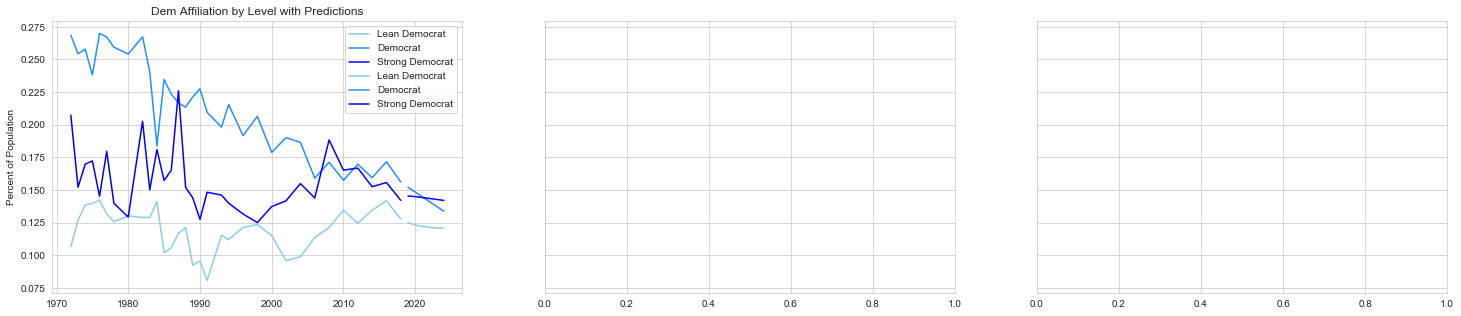

In [10]:
fig = plt.figure(figsize=(25,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(data= party_aff_lev['Lean Democrat'], 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Democrat'], 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Strong Democrat'], 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Lean Democrat'], 
             color = 'skyblue', label= 'Lean Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Democrat'], 
             color = 'dodgerblue', label= 'Democrat', ax = ax1)
sns.lineplot(data= party_aff_lev['Predicted Strong Democrat'], 
             color = 'blue', label= 'Strong Democrat', ax = ax1)
ax1.set_title('Dem Affiliation by Level with Predictions')
ax1.set_ylabel('Percent of Population')
ax1.set_xlabel('');

sns.lineplot(data= party_aff_lev['Strong Republican'], 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Republican'], 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Lean Republican'], 
             color= 'hotpink', label= 'Lean Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Strong Republican'], 
             color= 'crimson', label= 'Strong Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Republican'], 
             color= 'red', label= 'Republican', ax = ax2)
sns.lineplot(data= party_aff_lev['Predicted Lean Republican'], 
             color= 'hotpink', label= 'Lean Republican', ax = ax2)
ax2.set_title('Rep Affiliation by Level with Predictions')
ax2.set_xlabel('')

sns.lineplot(data=party_aff_ovr['Democrat'], 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(data=party_aff_ovr['Republican'], 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(data=party_aff_ovr['Independent'], 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(data=party_aff_ovr['Other'], 
             color= 'grey', label= 'Other', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Democrat'], 
             color= 'blue', label= 'Democrat', ax = ax3)
sns.lineplot(data=party_aff_ovr['Predicted Republican'], 
             color= 'red', label= 'Republican', ax = ax3)
sns.lineplot(x='year', y=, data=party_aff_ovr['Predicted Independent'], 
             color= 'plum', label= 'Independent', ax = ax3)
sns.lineplot(x='year', y='Predicted Other', data=party_aff_ovr, 
             color= 'grey', label= 'Other', ax = ax3)
ax3.set_title('Overall Affiliation with Predictions')
ax3.set_xlabel('')

Based on the projections it appears that party affiliation in America is trending toward more and more people identifying as independent. Meanwhile, within parties more and more people are identifying as Strong in their affiliation, even as affiliation with the party as a whole goes down.  

## Abortion Opinions
### Clean- Abortion Opinions

In [ ]:
abortion = unzip('Abortion')
abortion.info()

In [ ]:
abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')|
             (abortion['Married--wants no more children'] == 'Yes')|
             (abortion["Woman's health seriously endangered"] == 'Yes')|
             (abortion["Low income--cant afford more children"] == 'Yes')|
             (abortion["Pregnant as result of rape"] == 'Yes')|
             (abortion['Not married']=='Yes'), 'abortion'] = 'conditional'

abortion.loc[(abortion['Strong chance of serious defect'] == 'Yes')&
             (abortion['Married--wants no more children'] == 'Yes')&
             (abortion["Woman's health seriously endangered"] == 'Yes')&
             (abortion["Low income--cant afford more children"] == 'Yes')&
             (abortion["Pregnant as result of rape"] == 'Yes')&
             (abortion['Not married']=='Yes'), 'abortion'] = 'unrestricted'

abortion.loc[(abortion['Strong chance of serious defect'] == 'No')&
             (abortion['Married--wants no more children'] == 'No')&
             (abortion["Woman's health seriously endangered"] == 'No')&
             (abortion["Low income--cant afford more children"] == 'No')&
             (abortion["Pregnant as result of rape"] == 'No')&
             (abortion['Not married']=='No'), 'abortion'] = 'never'

abortion.loc[abortion['Abortion if woman wants for any reason']== 'Yes', 'abortion']= 'unrestricted'
abortion.head()

In [ ]:
abortion = abortion[['year','id', 'abortion']]
abortion = weight(abortion)
abortion_percentages = create_ts(abortion, ['unrestricted','conditional','never'])
abortion_percentages.head()

In [ ]:
sns.lineplot(x= 'year', y= 'unrestricted', data= abortion_percentages, 
             color = 'green', label='Unrestricted')
sns.lineplot(x= 'year', y= 'conditional', data= abortion_percentages, 
             color= 'yellow', label='Conditional')
sns.lineplot(x= 'year', y= 'never', data= abortion_percentages, 
             color= 'black', label='Banned');

In [ ]:
(rep_ts_abort, 
 dem_ts_abort, 
 ind_ts_abort) = party_splits(abortion,['unrestricted', 
                                        'conditional', 
                                        'never'])

In [ ]:
rep_preds_abort = pd.DataFrame()
dem_preds_abort = pd.DataFrame()
ind_preds_abort = pd.DataFrame()
for cat in ['unrestricted', 'conditional', 'never']:
    rep_preds_abort[cat] = make_preds(rep_ts_abort[cat])
    dem_preds_abort[cat] = make_preds(dem_ts_abort[cat])
    ind_preds_abort[cat] = make_preds(ind_ts_abort[cat])

In [ ]:
rep_preds_abort

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'unrestricted', data= rep_ts_abort, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= dem_ts_abort, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= ind_ts_abort, 
             color='purple', label= 'Independent', ax = ax1)
sns.lineplot(data= rep_preds_abort['unrestricted'], 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(data= dem_preds_abort['unrestricted'], 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(data= ind_preds_abort['unrestricted'], 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Unrestricted Access to Abortion by Party With Predictions')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'conditional', data= rep_ts_abort, 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= dem_ts_abort, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= ind_ts_abort, 
             color='purple', label= 'Independent', ax = ax2)
sns.lineplot(data= rep_preds_abort['conditional'], 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(data= dem_preds_abort['conditional'], 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(data= ind_preds_abort['conditional'], 
             color='purple', label= 'Independent', ax = ax2)
ax2.set_title('Conditional Access to Abortion by Party')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'never', data= rep_ts_abort, 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= dem_ts_abort, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= ind_ts_abort, 
             color='purple', label= 'Independent', ax = ax3)
sns.lineplot(data= rep_preds_abort['never'], 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(data= dem_preds_abort['never'], 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(data= ind_preds_abort['never'], 
             color='purple', label= 'Independent', ax = ax3)
ax3.set_title('Ban Access to Abortion by Party')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

It appears that access to abortion is increasingly a part of party identity. As we can see, the gap in beliefs about access to abortion has been increasing, with Democrats more likely to support unrestricted access, Republicans most likely to support conditions on access, and banning access altogether. 

In [ ]:
(str_rep_ts_abort, mid_rep_ts_abort, ln_rep_ts_abort, 
 str_dem_ts_abort, mid_dem_ts_abort, ln_dem_ts_abort, 
 oth_ts_abort, ind_ts_abort) = party_splits(abortion, ['unrestricted', 
                                     'conditional', 
                                     'never'], split = 'within party')

In [ ]:
str_rep_preds_abort = pd.DataFrame()
mid_rep_preds_abort = pd.DataFrame()
ln_rep_preds_abort = pd.DataFrame()
str_dem_preds_abort = pd.DataFrame()
mid_dem_preds_abort = pd.DataFrame()
ln_dem_preds_abort = pd.DataFrame()
oth_preds_abort = pd.DataFrame()
ind_preds_abort = pd.DataFrame()
for cat in ['unrestricted', 'conditional', 'never']:
    str_rep_preds_abort[cat] = make_preds(str_rep_ts_abort[cat])
    mid_rep_preds_abort[cat] = make_preds(mid_rep_ts_abort[cat])
    ln_rep_preds_abort[cat] = make_preds(ln_rep_ts_abort[cat])
    str_dem_preds_abort[cat] = make_preds(str_dem_ts_abort[cat])
    mid_dem_preds_abort[cat] = make_preds(mid_dem_ts_abort[cat])
    ln_dem_preds_abort[cat] = make_preds(ln_dem_ts_abort[cat])
    oth_preds_abort[cat] = make_preds(oth_ts_abort[cat])
    ind_preds_abort[cat] = make_preds(ind_ts_abort[cat])

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'unrestricted', data= str_rep_ts_abort, 
             color='red', label= 'Strong Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= mid_rep_ts_abort, 
             color='blue', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= ln_rep_ts_abort, 
             color='purple', label= 'Lean Republican', ax = ax1)
sns.lineplot(data=str_rep_preds_abort['unrestricted'], color='red', 
             ax = ax1)
sns.lineplot(data=mid_rep_preds_abort['unrestricted'], color='red', 
             ax = ax1)
sns.lineplot(data=ln_rep_preds_abort['unrestricted'], color='red', 
             ax = ax1)
ax1.set_title('Republican Support for Unrestricted Access to Abortion')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'conditional', data= str_rep_ts_abort, 
             color='red', label= 'Strong Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= mid_rep_ts_abort, 
             color='blue', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= ln_rep_ts_abort, 
             color='purple', label= 'Lean Republican', ax = ax2)
sns.lineplot(data=str_rep_preds_abort['conditional'], color='red', 
             ax = ax2)
sns.lineplot(data=mid_rep_preds_abort['conditional'], color='red', 
             ax = ax2)
sns.lineplot(data=ln_rep_preds_abort['conditional'], color='red', 
             ax = ax2)
ax2.set_title('Republican Support for Conditional Access to Abortion')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'never', data= str_rep_ts_abort, 
             color='red', label= 'Strong Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= mid_rep_ts_abort, 
             color='blue', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= ln_rep_ts_abort, 
             color='purple', label= 'Lean Republican', ax = ax3)
sns.lineplot(data=str_rep_preds_abort['never'], color='red', 
             ax = ax3)
sns.lineplot(data=mid_rep_preds_abort['never'], color='red', 
             ax = ax3)
sns.lineplot(data=ln_rep_preds_abort['never'], color='red', 
             ax = ax3)
ax3.set_title('Republican Support for Banning Access to Abortion')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'unrestricted', data= str_dem, 
             color='red', label= 'Strong Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= mid_dem, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'unrestricted', data= ln_dem, 
             color='purple', label= 'Lean Democrat', ax = ax1)
ax1.set_title('Democratic Support for Unrestricted Access to Abortion')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'conditional', data= str_dem, 
             color='red', label= 'Strong Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= mid_dem, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'conditional', data= ln_dem, 
             color='purple', label= 'Lean Democrat', ax = ax2)
ax2.set_title('Democratic Support for Conditional Access to Abortion')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'never', data= str_dem, 
             color='red', label= 'Strong Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= mid_dem, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'never', data= ln_dem, 
             color='purple', label= 'Lean Democrat', ax = ax3)
ax3.set_title('Democratic Support for Banning Access to Abortion')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

This trend is even more clear in these graphs, where we can see clearly that the more affiliated a person is the more likely that they support an outright ban. 

## Criminal Justice Attitudes

In [ ]:
crim_justice = unzip('Criminal_Justice')
crim_justice.columns

In [ ]:
crim_justice[crim_justice['Ever approve of police striking citizen']=='Yes']['Citizen attacking policeman with fists'].value_counts()

The police striking citizens columns lack information on how the police response is defined, and will likely be difficult to interpret given the nature of this analysis. Unfortunately I will have to drop them. 

In [ ]:
crim_justice.drop(['Citizen attacking policeman with fists', 
                   'Citizen attempting to escape custody', 
                   'Citizen questioned as murder suspect', 
                   'Citizen said vulgar or obscene things', 
                   'Ever approve of police striking citizen'], axis = 1, inplace = True)

In [ ]:
crim_justice.rename(columns = {'Should marijuana be made legal': 'legalize_marijuana',
                             'Courts dealing with criminals': 'sentencing',
                             'Favor or oppose death penalty for murder': 'death_penalty', 
                             'Afraid to walk at night in neighborhood': 'fear'}, inplace=True)

In [ ]:
crim_justice = weight(crim_justice)

In [ ]:
crim_justice['legalize_marijuana'].unique()

In [ ]:
rep_ts_mj, dem_ts_mj, ind_ts_mj = party_splits(crim_justice, 
                                               ['Legal',
                                                'Not legal'])

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.subplots(nrows=1, ncols=1, sharey= True)

sns.lineplot(x= 'year', y= 'Legal', data= rep_ts_mj, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'Legal', data= dem_ts_mj, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'Legal', data= ind_ts_mj, 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Legalization of Marijuana by Party')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

Clearly, attitudes about the legalization of marijuana have changed in favor of legalization, with Democrats leading the way. Another example of a widening partisan divide around certain issues. 

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(crim_justice, ['Legal', 
                                     'Not legal'], split = 'within party')

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'Legal', data= str_rep, 
             color='red', label= 'Strong Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'Legal', data= mid_rep, 
             color='blue', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'Legal', data= ln_rep, 
             color='purple', label= 'Lean Republican', ax = ax1)
ax1.set_title('Legalization of Marijuana by Republican Affiliation')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'Legal', data= str_dem, 
             color='red', label= 'Strong Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'Legal', data= mid_dem, 
             color='blue', label= 'Democratic', ax = ax2)
sns.lineplot(x= 'year', y= 'Legal', data= ln_dem, 
             color='purple', label= 'Lean Democratic', ax = ax2)
ax2.set_title('Conditional Access to Abortion by Party')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'Legal', data= oth, 
             color='red', label= 'Other', ax = ax3)
sns.lineplot(x= 'year', y= 'Legal', data= ind, 
             color='blue', label= 'Independent', ax = ax3)
ax3.set_title('Ban Access to Abortion by Party')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

In [ ]:
crim_justice['sentencing'].unique()

In [ ]:
rep_ts_sen, dem_ts_sen, ind_ts_sen = party_splits(crim_justice, 
                                               ['About right',
                                                'Not harsh enough', 
                                                'Too harsh'])

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'About right', data= rep_ts_sen, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'About right', data= dem_ts_sen, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'About right', data= ind_ts_sen, 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Criminal Sentencing is about right')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'Not harsh enough', data= rep_ts_sen, 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'Not harsh enough', data= dem_ts_sen, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'Not harsh enough', data= ind_ts_sen, 
             color='purple', label= 'Independent', ax = ax2)
ax2.set_title('Criminal Sentencing is not harsh enough')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'Too harsh', data= rep_ts_sen, 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'Too harsh', data= dem_ts_sen, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'Too harsh', data= ind_ts_sen, 
             color='purple', label= 'Independent', ax = ax3)
ax3.set_title('Criminal Sentencing is too harsh')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

It seems as though the people who think criminal sentencing is about right are not clearly from one party or another. When it comes to sentencing otherwise a more clear difference emerges. 

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(crim_justice, ['About right',
                                         'Not harsh enough', 
                                         'Too harsh'], split='within party')

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey= True)

sns.lineplot(x= 'year', y= 'About right', data= str_rep, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'About right', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'About right', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Criminal Sentencing is about right')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'Not harsh enough', data= str_rep, 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'Not harsh enough', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'Not harsh enough', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax2)
ax2.set_title('Criminal Sentencing is not harsh enough')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'Too harsh', data= str_rep, 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'Too harsh', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'Too harsh', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax3)
ax3.set_title('Criminal Sentencing is too harsh')
ax3.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

###### Systems

In [ ]:
systems = unzip('Systems')
systems.columns

In [ ]:
for col in systems.columns:
    print(systems[col].value_counts())
    print('\n')

In [ ]:
systems.drop(['Confidence in medicine'], axis = 1, inplace = True)

In [ ]:
systems = weight(systems)

###### Gender and Sexuality

In [ ]:
gender = unzip('Gender_and_Sexuality')
gender.columns

In [ ]:
for col in gender.columns:
    print(gender[col].value_counts())
    print('\n')

In [ ]:
gender.drop(['Should hire and promote women                            ', 
             'For or against preferential hiring of women      ', 
             'Better for man to work, woman tend home', 'Preschool kids suffer if mother works',
             'Sex before marriage -- teens 14-16', 'Birth control to teenagers 14-16'], 
            axis = 1, inplace = True)

In [ ]:
gender.rename(columns ={'Sex before marriage':'sex_before_marr',
                        'Divorce laws': 'divorce', 
                        'Sex education in public schools':'sex_ed',
                        'Women not suited for politics': 'no_women_pol',
                        'Homosexuals should have right to marry':'gay_marr'}, inplace=True)

In [ ]:
gender = weight(gender)

In [ ]:
gender.loc[(gender['gay_marr']=='Neither agree nor disagree')|
           (gender['gay_marr']=='Cant choose'), 'gay_marr']= 'undecided'

In [ ]:
gender['gay_marr'].unique()

In [ ]:
(rep_ts_gay, dem_ts_gay, ind_ts_gay) = party_splits(gender[['year', 'gay_marr']], ['Strongly disagree', 
                                         'undecided',
                                         'Disagree',
                                         'Agree', 
                                         'Strongly agree'])

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(nrows=1, ncols=5, sharey= True)

sns.lineplot(x= 'year', y= 'Strongly disagree', data= rep_ts_gay, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'Strongly disagree', data= dem_ts_gay, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'Strongly disagree', data= ind_ts_gay, 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Strongly Disagree with Right to Marry by Party')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'Disagree', data= rep_ts_gay, 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'Disagree', data= dem_ts_gay, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'Disagree', data= ind_ts_gay, 
             color='purple', label= 'Independent', ax = ax2)
ax2.set_title('Disagree with Right to Marry by Party')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'undecided', data= rep_ts_gay, 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'undecided', data= dem_ts_gay, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'undecided', data= ind_ts_gay, 
             color='purple', label= 'Independent', ax = ax3)
ax3.set_title('Undecided about right to Marry by Party')
ax3.set_xlabel('')

sns.lineplot(x= 'year', y= 'Agree', data= rep_ts_gay, 
             color='red', label= 'Republican', ax = ax4)
sns.lineplot(x= 'year', y= 'Agree', data= dem_ts_gay, 
             color='blue', label= 'Democrat', ax = ax4)
sns.lineplot(x= 'year', y= 'Agree', data= ind_ts_gay, 
             color='purple', label= 'Independent', ax = ax4)
ax4.set_title('Agree with right to Marry by Party')
ax4.set_xlabel('')

sns.lineplot(x= 'year', y= 'Strongly agree', data= rep_ts_gay, 
             color='red', label= 'Republican', ax = ax5)
sns.lineplot(x= 'year', y= 'Strongly agree', data= dem_ts_gay, 
             color='blue', label= 'Democrat', ax = ax5)
sns.lineplot(x= 'year', y= 'Strongly agree', data= ind_ts_gay, 
             color='purple', label= 'Independent', ax = ax5)
ax5.set_title('Strongly Agree with right to Marry by Party')
ax5.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

In [ ]:
(str_rep, mid_rep, ln_rep, 
 str_dem, mid_dem, ln_dem, 
 oth, ind) = party_splits(gender[['year','gay_marr']], ['Strongly disagree', 
                                         'undecided',
                                         'Disagree',
                                         'Agree', 
                                         'Strongly agree'], split='within party')

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(nrows=1, ncols=5, sharey= True)

sns.lineplot(x= 'year', y= 'Strongly disagree', data= str_rep, 
             color='red', label= 'Republican', ax = ax1)
sns.lineplot(x= 'year', y= 'Strongly disagree', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax1)
sns.lineplot(x= 'year', y= 'Strongly disagree', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax1)
ax1.set_title('Strongly Disagree with Right to Marry by Party')
ax1.set_ylabel('Percent of Party')
ax1.set_xlabel('')

sns.lineplot(x= 'year', y= 'Disagree', data= str_rep, 
             color='red', label= 'Republican', ax = ax2)
sns.lineplot(x= 'year', y= 'Disagree', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax2)
sns.lineplot(x= 'year', y= 'Disagree', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax2)
ax2.set_title('Disagree with Right to Marry by Party')
ax2.set_xlabel('')

sns.lineplot(x= 'year', y= 'undecided', data= str_rep, 
             color='red', label= 'Republican', ax = ax3)
sns.lineplot(x= 'year', y= 'undecided', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax3)
sns.lineplot(x= 'year', y= 'undecided', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax3)
ax3.set_title('Undecided about right to Marry by Party')
ax3.set_xlabel('')

sns.lineplot(x= 'year', y= 'Agree', data= str_rep, 
             color='red', label= 'Republican', ax = ax4)
sns.lineplot(x= 'year', y= 'Agree', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax4)
sns.lineplot(x= 'year', y= 'Agree', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax4)
ax4.set_title('Agree with right to Marry by Party')
ax4.set_xlabel('')

sns.lineplot(x= 'year', y= 'Strongly agree', data= str_rep, 
             color='red', label= 'Republican', ax = ax5)
sns.lineplot(x= 'year', y= 'Strongly agree', data= mid_rep, 
             color='blue', label= 'Democrat', ax = ax5)
sns.lineplot(x= 'year', y= 'Strongly agree', data= ln_rep, 
             color='purple', label= 'Independent', ax = ax5)
ax5.set_title('Strongly Agree with right to Marry by Party')
ax5.set_xlabel('')

plt.yticks(ticks=[.15, .3, .45, .6, .75], 
           labels=['','15%', '30%', '45%', '60%', '75%']);

###### Opinions

In [ ]:
opinions = unzip('Opinions')
opinions.columns

In [ ]:
for col in opinions.columns:
    print(opinions[col].value_counts())
    print('\n')

In [ ]:
opinions = weight(opinions)

###### Race Relations

In [ ]:
race = unzip('Race_Relations')
race.columns

In [ ]:
for col in race.columns:
    print(race[col].value_counts())
    print('\n')

Because of the ways in which these variables were coded, many of them are either redundant with other questions, or difficult to gain meaningful information from.  

In [ ]:
race.drop(['Hard working - lazy', 'Hard working - lazy.1', 
           'Rich - poor', 'Rich - poor.1', 'Blacks overcome prejudice without favors ',
           'Any opp. race in neighborhood', 'Favor law against racial intermarriage', 
           'Improving the conditions of blacks'], axis = 1, inplace = True)

In [ ]:
race.loc[race['Should govt aid blacks?']=='Agree with both', 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=='No special treatment', 'Should govt aid blacks?']= 'strongly oppose'
race.loc[race['Should govt aid blacks?']== 4, 'Should govt aid blacks?']= 'oppose'
race.loc[race['Should govt aid blacks?']=='Govt help blks', 'Should govt aid blacks?']= 'strongly favor'
race.loc[race['Should govt aid blacks?']== 2, 'Should govt aid blacks?']= 'favor'
race.loc[race['Should govt aid blacks?']=="Don't know", 'Should govt aid blacks?']= 'no opinion'
race.loc[race['Should govt aid blacks?']=="No answer", 'Should govt aid blacks?']= 'no opinion'

In [ ]:
race = weight(race)

##### Education

In [ ]:
education = unzip('Education')
education.columns

In [ ]:
for col in education.columns:
    print(education[col].value_counts())
    print('\n')

With so many not applicable entries for the field of degree, it is more appropriate to remove them from the analysis. 

In [ ]:
education.drop(['The field of degree r earned'], axis=1, inplace=True)

In [ ]:
education.rename(columns = {'Highest year of school completed':'school_years',
                            'Highest year school completed, father':'school_years_dad', 
                            'Highest year school completed, mother':'school_years_mom',
                            'Rs highest degree':'degree',
                            'Fathers highest degree':'degree_dad',
                            'Mothers highest degree': 'degree_mom'}, inplace=True)

Encode nan information as a placeholder so that it can be easily removed later in the analysis. 

In [ ]:
education.loc[(education['school_years']=='No answer')|
              (education['school_years']=='Not applicable')|
              (education['school_years']== "Don't know"), 'school_years']= -9
education.loc[(education['school_years_dad']=='No answer')|
              (education['school_years_dad']=='Not applicable')|
              (education['school_years_dad']== "Don't know"), 'school_years_dad']= -9
education.loc[(education['school_years_mom']=='No answer')|
              (education['school_years_mom']=='Not applicable')|
              (education['school_years_mom']== "Don't know"), 'school_years_mom']= -9

In [ ]:
education.head()

In [ ]:
education = weight(education)

##### Employment

In [ ]:
employment = unzip('Employment')
employment.columns

In [ ]:
for col in employment.columns:
    print(employment[col].value_counts())
    print('\n')

In [ ]:
employment.drop(['Is r likely to lose job', 'Could r find equally good job', 
                 'Job or housework', 'If rich, continue or stop working', 
                 'Workers need strong unions'], axis=1, inplace = True)

In [ ]:
employment.rename(columns= {'Does r or spouse belong to union': 'union',
                            'Number of hours usually work a week': 'wrk_hrs',
                            'Labor force status': 'job_status',
                            'Rs occupational prestige score using threshold method (2010)': 'prestige'}, 
                  inplace = True)

In [ ]:
employment.loc[(employment['union']=='Neither belongs', 'union')]= 'non-member'
employment.loc[(employment['union']=='R belongs')|
               (employment['union']=='Spouse belongs')|
               (employment['union']=='R and spouse belong'), 'union']= 'member'

In [ ]:
employment.head()

In [ ]:
employment = weight(employment)

###### Family Values

In [ ]:
fam_vals = unzip('Family_Values')
fam_vals.columns

In [ ]:
for col in fam_vals.columns:
    print(fam_vals[col].value_counts())
    print('\n')

In [ ]:
fam_vals.rename(columns= {'Better for man to work, woman tend home': 'trad_roles', 
                          'Preschool kids suffer if mother works': 'mom_wrk_kids_suffer', 
                          'Ideal number of children': 'bst_num_chld', 
                          'To help others': 'tch_to_help',
                          'To work hard': 'tch_to_wrk', 
                          'To think for ones self': 'tch_ind', 
                          'To be well liked or popular': 'tch_pop',
                          'To obey': 'tch_obey', 
                          'Number of children': 'num_chld',
                          'Number of family generations in household': 'num_gen'}, inplace=True)

In [ ]:
fam_vals.drop(['Rs kids living standard compared to r', 'Rs living standard compared to parents', 
               'Highest year school completed, mother', 'Highest year school completed, father', 
               'Number of brothers and sisters', 'Favor spanking to discipline child'], axis=1, inplace=True)

In [ ]:
fam_vals.loc[fam_vals['num_gen']=='1 gen', 'num_gen']= 1
fam_vals.loc[(fam_vals['num_gen']=='2 gens, children')|
             (fam_vals['num_gen']=='2 gens, parents')|
             (fam_vals['num_gen']=='2 gens, grandchldrn'), 'num_gen']= 2
fam_vals.loc[(fam_vals['num_gen']=='3 gens, grandchldrn')|
             (fam_vals['num_gen']=='3 gens, chld, par'), 'num_gen']= 3
fam_vals.loc[fam_vals['num_gen']=='4 gens', 'num_gen']= 4

In [ ]:
fam_vals.head()

In [ ]:
fam_vals = weight(fam_vals)

###### Identity

In [ ]:
pers_id = unzip('Identity')
pers_id.columns

In [ ]:
for col in pers_id.columns:
    print(pers_id[col].value_counts())
    print('\n')

In [ ]:
pers_id.rename(columns={'Age of respondent':'age', 
                      'Respondents sex':'sex', 
                      'Race of respondent':'race',
                      'Region of interview':'region'}, inplace = True)

In [ ]:
pers_id = weight(pers_id)

###### Lifestyle

In [ ]:
lifestyle = unzip('Lifestyle')
lifestyle.columns

In [ ]:
for col in lifestyle.columns:
    print(lifestyle[col].value_counts())
    print('\n')

In [ ]:
lifestyle.rename(columns = {'Hours per day watching tv':'hrs_tv',
                            'How often does r read newspaper':'paper',
                            'Have gun in home':'gun',
                            'Is life exciting or dull':'life',
                            'General happiness':'happy',
                            "R's age when 1st child born":'age_at_frst_chld',
                            'Marital status':'married',
                            'Does r own or rent home?':'rent_or_own'}, inplace = True)

In [ ]:
lifestyle.drop(['Does r or spouse hunt', 'Spend evening at bar', 
                'Spend evening with friends', 'Spend evening with neighbor', 
                'Spend evening with relatives', 'Age of respondent', 'Number of children',
                'Number of hours usually work a week'], axis=1, inplace=True)

In [ ]:
lifestyle = weight(lifestyle)

###### Religion

In [ ]:
religion = unzip('Religion')
religion.columns

In [ ]:
for col in religion.columns:
    print(religion[col].value_counts())
    print('\n')

In [ ]:
religion.drop(['Bible prayer in public schools'], axis = 1, inplace = True)

In [ ]:
religion = weight(religion)

###### Socioeconomic Status

In [ ]:
ses = unzip('SES')
ses.columns

In [ ]:
for col in ses.columns:
    print(ses[col].value_counts())
    print('\n')

In [ ]:
ses.drop(['Rs income in constant $', 'Standard of living of r will improve', 
          'Rs kids living standard compared to r', 'Rs living standard compared to parents', 
          'Change in financial situation', 'Rs occupational prestige score using threshold method (2010)'], 
         axis = 1, inplace = True)

In [ ]:
ses = weight(ses)

#### Family/ SES Background

In [ ]:
background = unzip('Background')

In [ ]:
background.columns

In [ ]:
for col in background.columns:
    print(background[col].value_counts())
    print('\n')

In [ ]:
background.rename(columns = {"Father's occupational prestige score using threshold method (2010)": 'father_prestige',
                             "Mother's occupational prestige score using threshold method (2010)": 'mother_prestige',
                             'Religion in which raised': 'raised_relig', 
                             'How many grandparents born outside u.s.': 'immigrant_gpar', 
                             'Were rs parents born in this country': 'immigrant_par', 
                             'Was r born in this country': 'immigrant'}, inplace=True)

I will encode the immigration status of parents so that the number of grandparents and parents born outside of the country are counted. Parents born in the U.S will be coded as 0s. Because this data will likely not be used for modeling, I will keep not applicable values as they are. 

In [ ]:
background.loc[(background['raised_relig']=='Not applicable')|
               (background['raised_relig']=='No answer')|
               (background['raised_relig']=="Don't know"), 'raised_relig']= 'Other'
background.loc[(background['immigrant_gpar']== 'All in u.s'), 'immigrant_gpar']= 0
background.loc[(background['immigrant_par']=='Both in u.s')|
               (background['immigrant_par']=='Mother; fa. dk')|
               (background['immigrant_par']=='Father; mo.dk'), 'immigrant_par']= 0
background.loc[(background['immigrant_par']=='Neither in u.s')|
               (background['immigrant_par']=='Not mother;fa.dk')|
               (background['immigrant_par']=='Not father;mo.dk'), 'immigrant_par']= 2
background.loc[(background['immigrant_par']=='Mother only')|
               (background['immigrant_par']=='Father only'), 'immigrant_par']= 1
background.loc[(background['immigrant']=='Yes'), 'immigrant']= 'no'
background.loc[(background['immigrant']=='No'), 'immigrant']= 'yes'
background.loc[(background['immigrant']=='Not applicable')|
               (background['immigrant']=='No answer')|
               (background['immigrant']=="Don't know"), 'immigrant']= 'n/a'

The 'Rs living standard compared to parents' is messy and highly incomplete, so I will drop it for this analysis. In addition, after consideration, parental education levels are more appropriately placed in the education table so they will also be dropped from this table.  

In [ ]:
background.drop(['Rs living standard compared to parents', 
                 'Fathers highest degree', 'Mothers highest degree'], axis= 1, inplace= True)

In [ ]:
background = weight(background)

# Text Data
### Political Platforms

In [ ]:
years = ['1972', '1976', '1980', '1984', '1988', '1992', '1996', 
         '2000', '2008', '2012', '2016']
platforms = scrape_platforms(years)
platforms.head()

### State of the Union Addresses

In [ ]:
speeches = scrape_SotU()

### Debates

In [ ]:
url = 'https://www.presidency.ucsb.edu/documents/presidential-debate-the-university-nevada-las-vegas'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
debate = soup.find_all('p')
for deb in debate:
    print(deb.text)